# Running custom JAX augmentations in DALI

This tutorial shows how to run JAX functions inside DALI pipeline or iterator using [plugin.jax.fn.jax_function](../../operations/nvidia.dali.plugin.jax.fn.jax_function.html). This way, you can write custom augmentations in JAX and make them interoperable with other DALI operations.

## Setting up the example

We will start with a simple image-processing DALI iterator. You can read more on how to define iterator for JAX with DALI in [DALI and JAX getting started](../frameworks/jax/jax-getting_started.html).

In [1]:
import nvidia.dali.fn as fn
from nvidia.dali.plugin.jax import data_iterator

image_dir = "../data/images"


@data_iterator(output_map=["images", "labels"], reader_name="image_reader")
def baseline_iterator_fn():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, size=(300, 300))
    return images, labels


baseline_iterator = baseline_iterator_fn(batch_size=4)

baseline_batch = next(baseline_iterator)

I0000 00:00:1712925383.509577   95651 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Let us define a simple helper function to present the produced batch, we will use it later.

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec


def show_image(images, columns=4, fig_size=24):
    rows = (len(images) + columns - 1) // columns
    plt.figure(figsize=(fig_size, (fig_size // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(images[j])

## Adding an augmentation defined with JAX

Now, let us add some JAX processing to the picture. As a simple example, we will flip the images horizontally using `jax.numpy` array indexing.

We import `jax` and write a function that expects a 4D array - a batch of `HWC` images. Similarily, the function returns 4D array, just with the `W` dimension is reversed.

In [3]:
import jax


def horz_flip(images: jax.Array):
    return images[:, :, ::-1, :]

To plug the `horz_flip` into the iterator we need to transform the function using `jax_function`.

In [4]:
from nvidia.dali.plugin.jax.fn import jax_function


@jax_function
def horz_flip(images: jax.Array):
    return images[:, :, ::-1, :]

That is it, we can call the function as a regular DALI operation inside the iterator definition.

In [5]:
@data_iterator(output_map=["images", "labels"], reader_name="image_reader")
def iterator_fn():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, size=(300, 300))

    images = horz_flip(images)

    return images, labels


iterator = iterator_fn(batch_size=4)
batch = next(iterator)

Let us compare the output of the baseline iterator and the one that uses `horz_flip`.

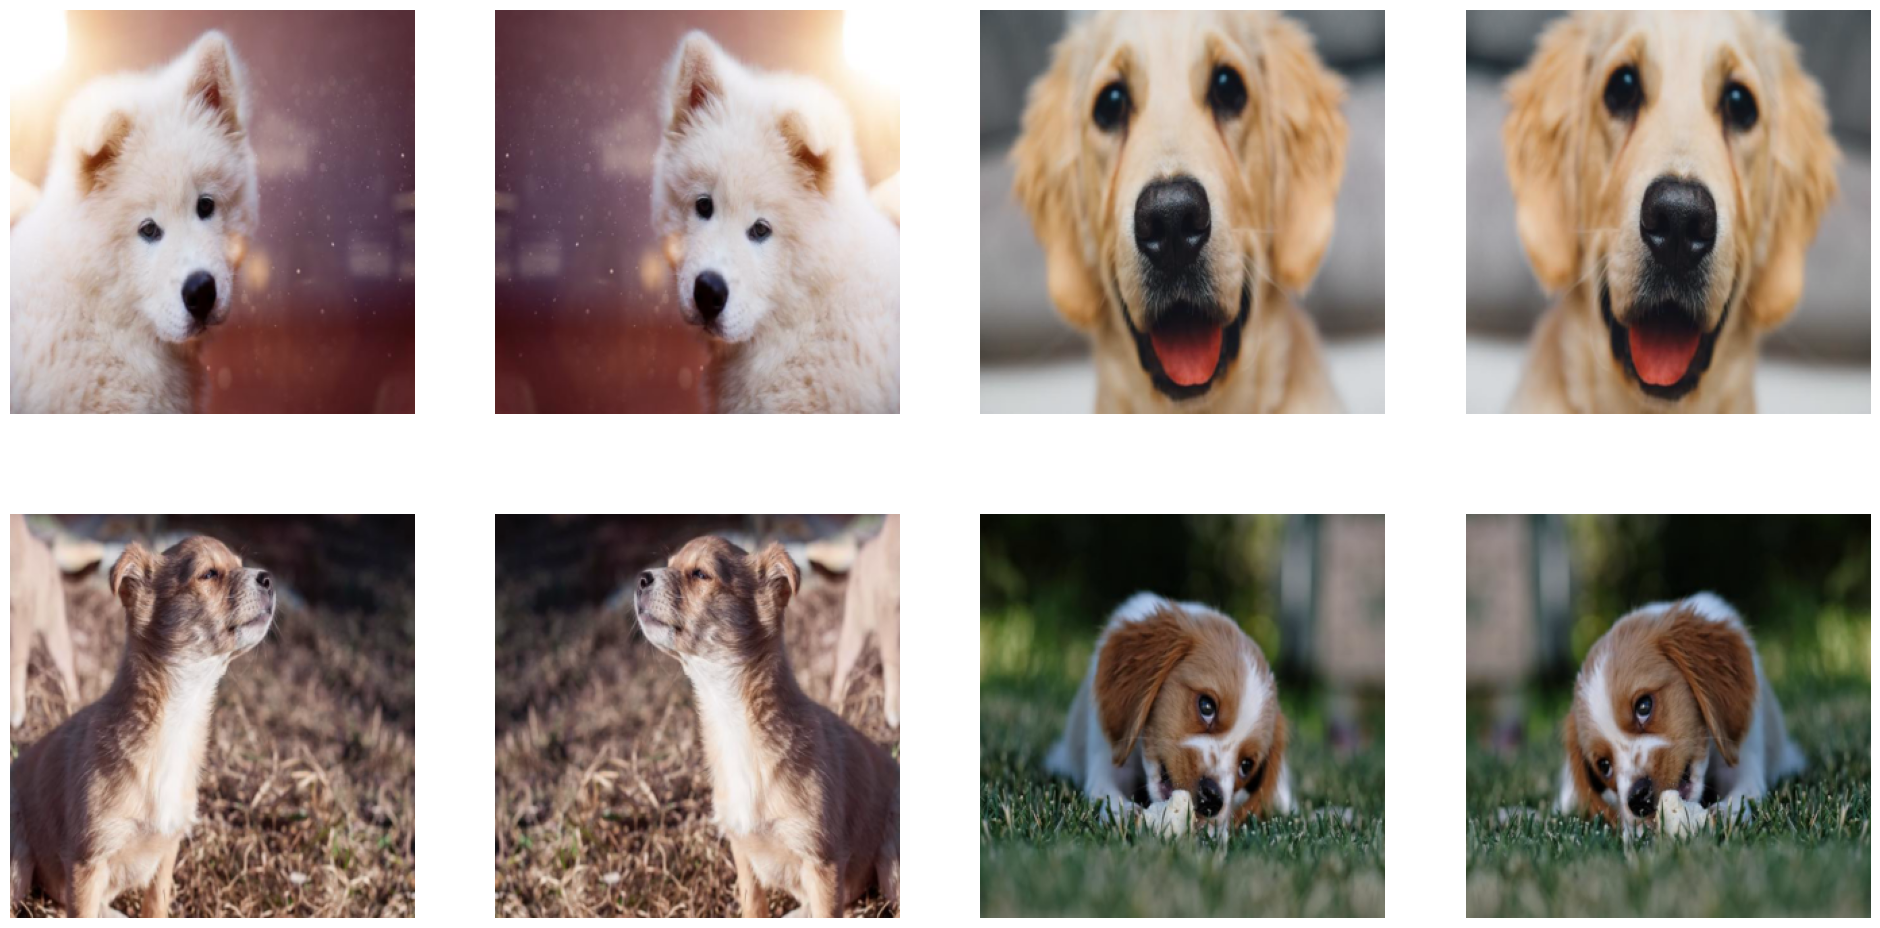

In [6]:
show_image([image for pair in zip(baseline_batch["images"], batch["images"]) for image in pair])

## JAX function transformations

The `jax_function` can be combined with common JAX transformations. For example we can use `jax.vmap` to vectorize the processing along batch dimension, `jax.jit` to get benefits of JAX's just in time compilation, or use both.

The one thing to note is that `jax_function` must be the outermost transformation.

In [7]:
@jax_function
@jax.vmap
def horz_flip(image: jax.Array):
    return image[:, ::-1, :]  # single HWC image


@jax_function
@jax.jit
def horz_flip(images: jax.Array):
    return images[:, :, ::-1, :]  # batch of HWC images


@jax_function
@jax.jit
@jax.vmap
def horz_flip(image: jax.Array):
    return images[:, ::-1, :]  # batch of HWC images, the operation is jitted

## Multiple inputs and outputs

Next, let us add another argument to the `horz_flip` that will controll if the given image should be flipped or left unchanged. We will flip the image depending on the output of DALI's `fn.random.coin_flip()`.

In [8]:
@jax_function
@jax.jit
@jax.vmap
def horz_flip(image: jax.Array, should_flip: jax.Array):
    return jax.lax.cond(should_flip, lambda x: x[:, ::-1, :], lambda x: x, image)

In [9]:
@data_iterator(output_map=["images", "labels"], reader_name="image_reader")
def iterator_fn():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, size=(300, 300))
    should_flip = fn.random.coin_flip(seed=45)
    # note, currently all the inputs must reside on the same backend type,
    # as images are in GPU memory, we need to move should_flip there as well.
    images = horz_flip(images, should_flip.gpu())
    return images, labels


iterator = iterator_fn(batch_size=8)
batch = next(iterator)  # batch of data ready to be used by JAX

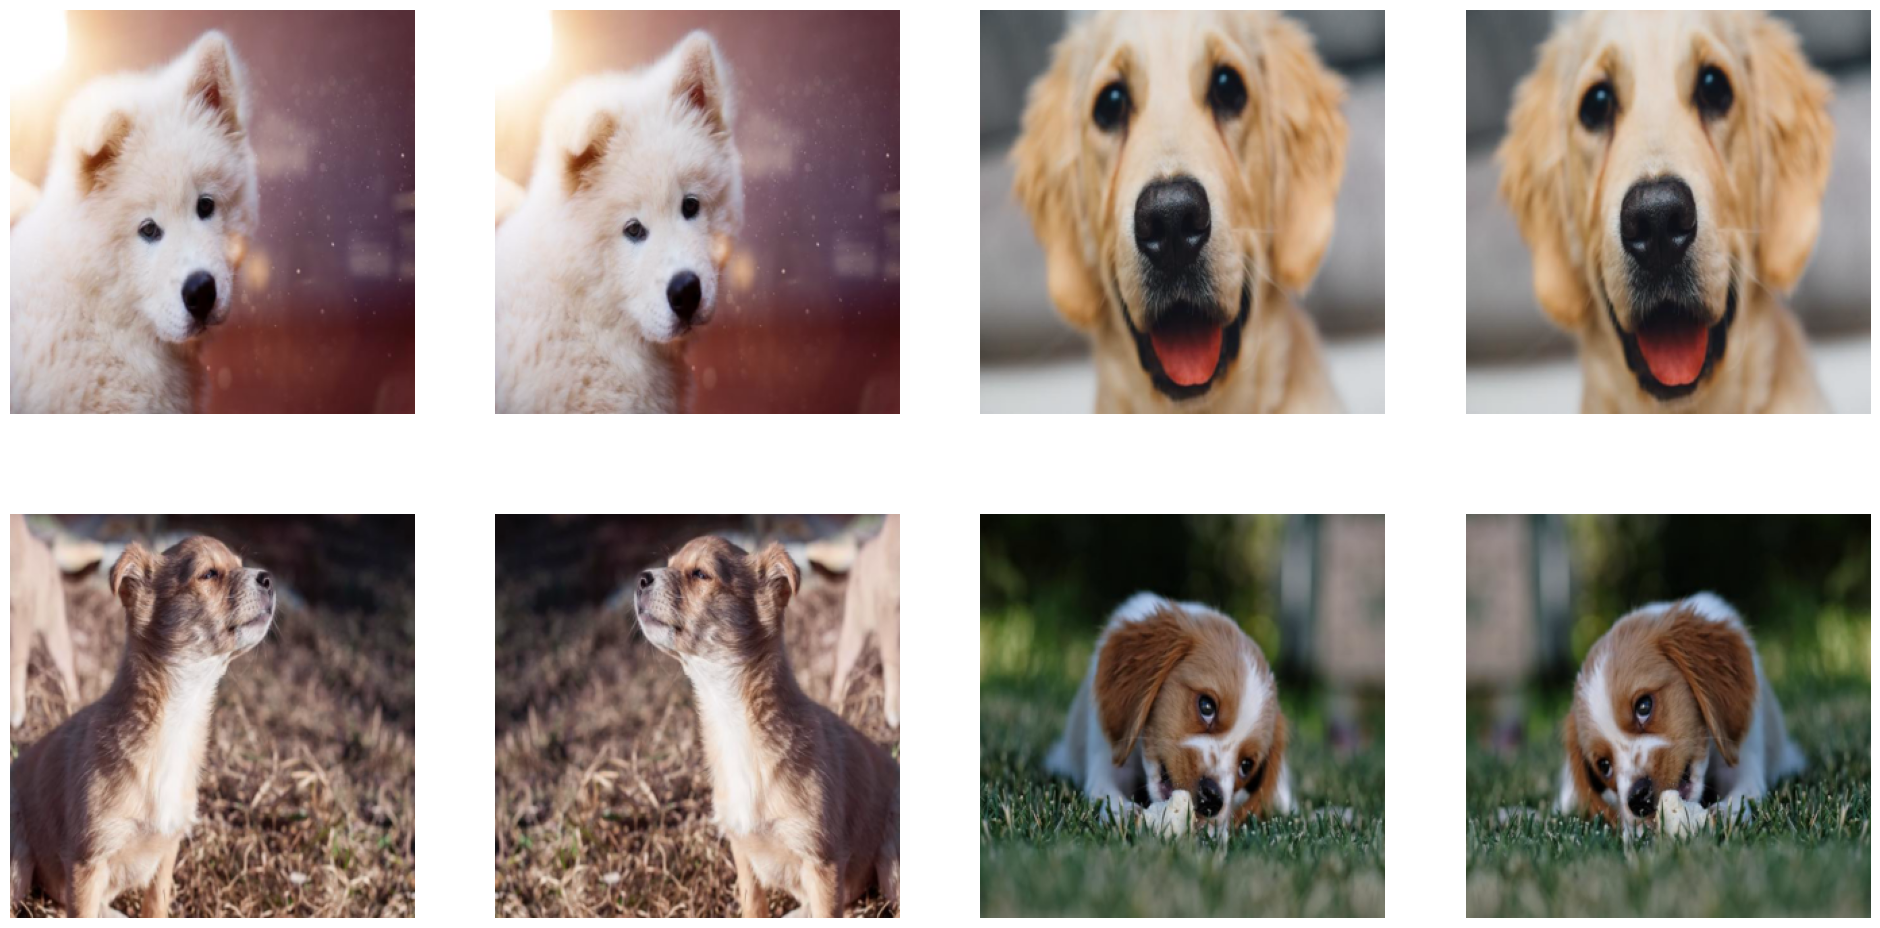

In [10]:
show_image(
    [image for pair in zip(baseline_batch["images"], batch["images"]) for image in pair], columns=4
)

As expected, some of the images are left unchanged.

We have just seen that the processing function can accept multiple inputs. Similarily, it can return multiple outputs. For that, however, we need to hint DALI how many outputs it should expect. We can do that passing the `num_outputs` to the `jax_function`.

In [11]:
@jax_function(num_outputs=2)
@jax.jit
@jax.vmap
def flip(image: jax.Array):
    horz_flip = image[:, ::-1, :]
    vert_flip = image[::-1, :, :]
    return horz_flip, vert_flip

In [12]:
@data_iterator(output_map=["horz", "vert", "labels"], reader_name="image_reader")
def iterator_fn():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, size=(300, 300))
    horz_flipped, vert_flipped = flip(images)
    return horz_flipped, vert_flipped, labels


iterator = iterator_fn(batch_size=2)
batch = next(iterator)  # batch of data ready to be used by JAX

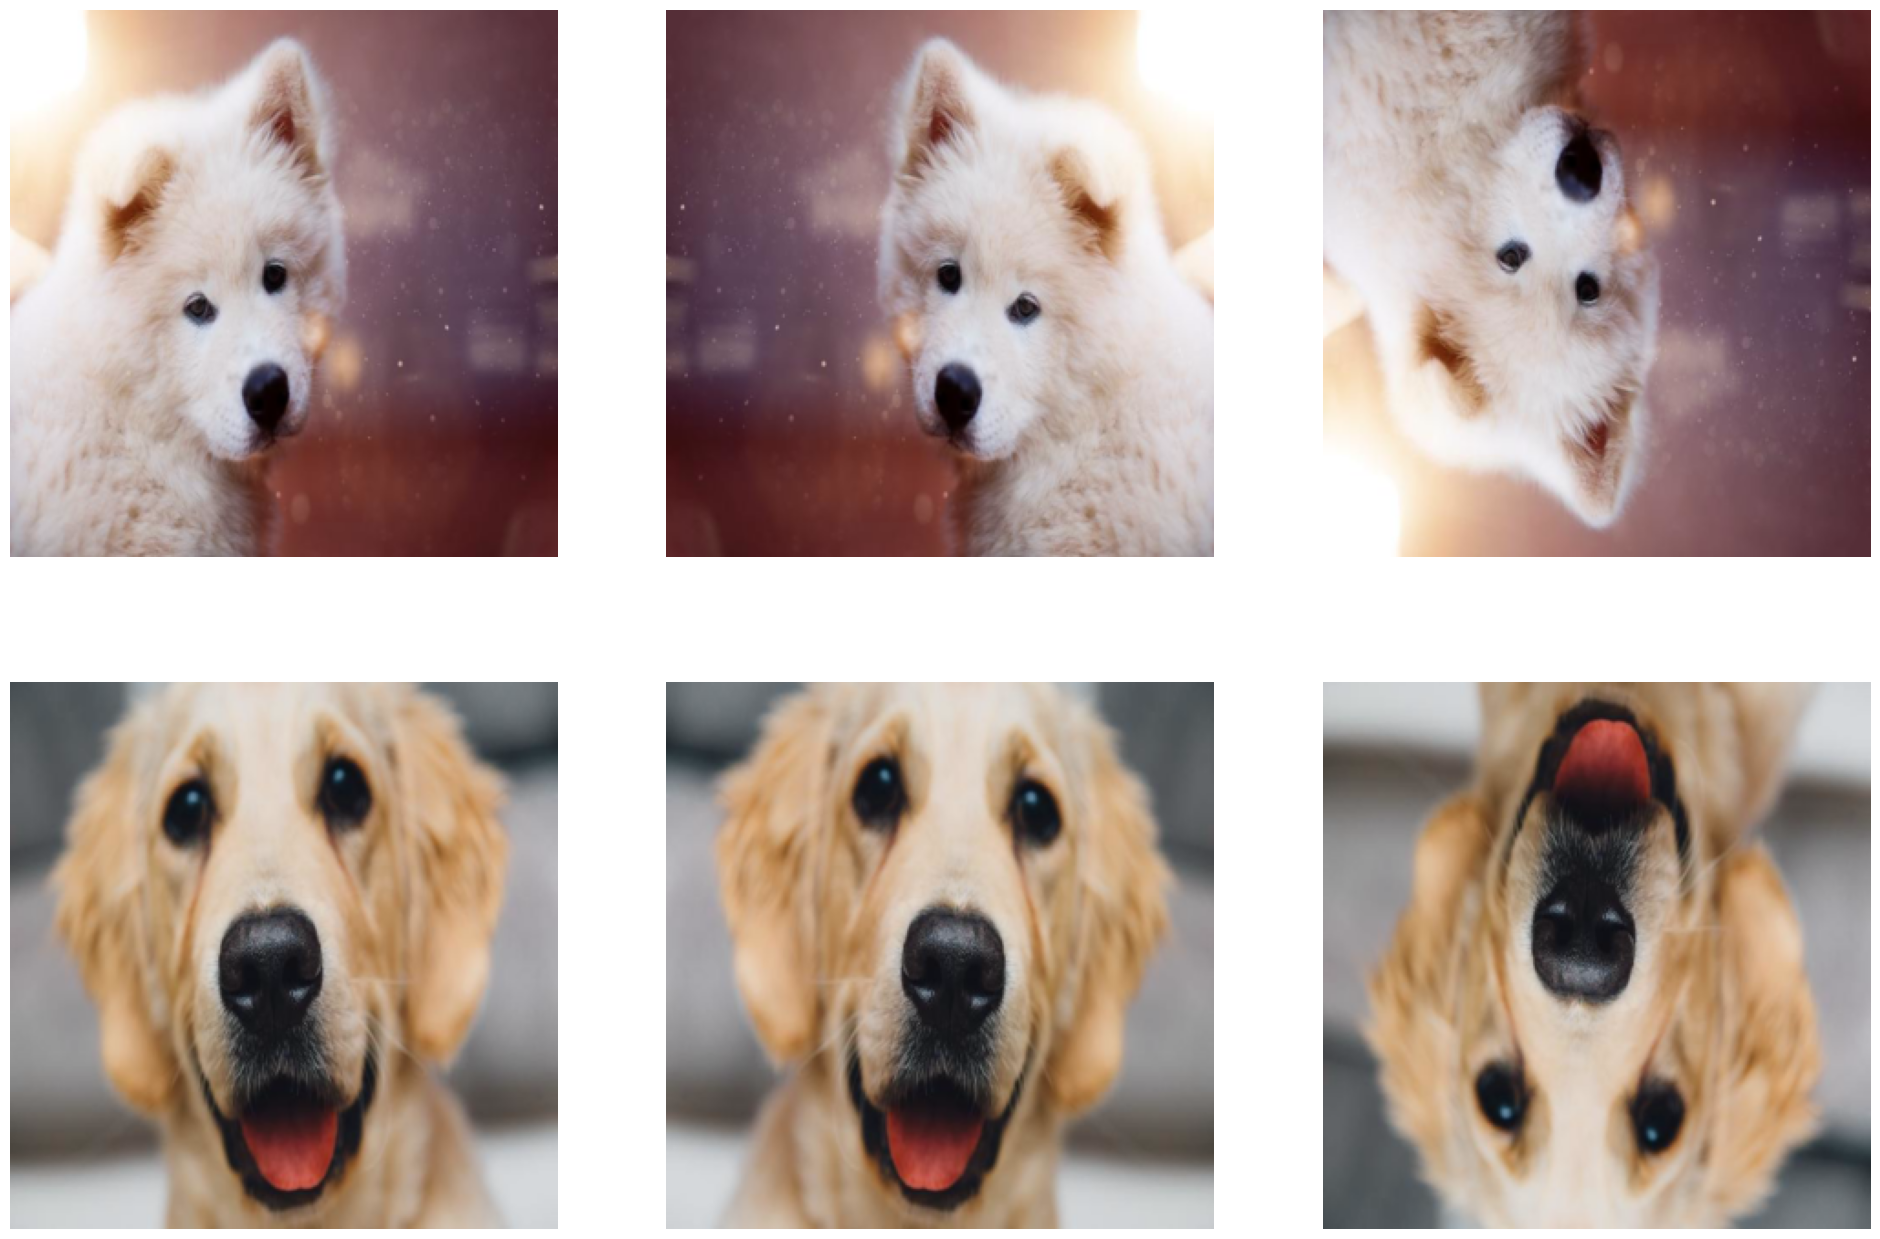

In [13]:
show_image(
    [
        image
        for triple in zip(baseline_batch["images"], batch["horz"], batch["vert"])
        for image in triple
    ],
    columns=3,
)

## JAX augmentations in regular pipelines

The JAX agumentations are not limited to JAX iterators, they can work with regular DALI pipelines too.

In [14]:
from nvidia.dali import pipeline_def


@pipeline_def(batch_size=4, device_id=0, num_threads=4)
def pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, size=(300, 300))
    should_flip = fn.random.coin_flip(seed=44)
    flipped_images = horz_flip(images, should_flip.gpu())
    return images, flipped_images, labels


p = pipeline()
p.build()
images, flipped_images, labels = p.run()

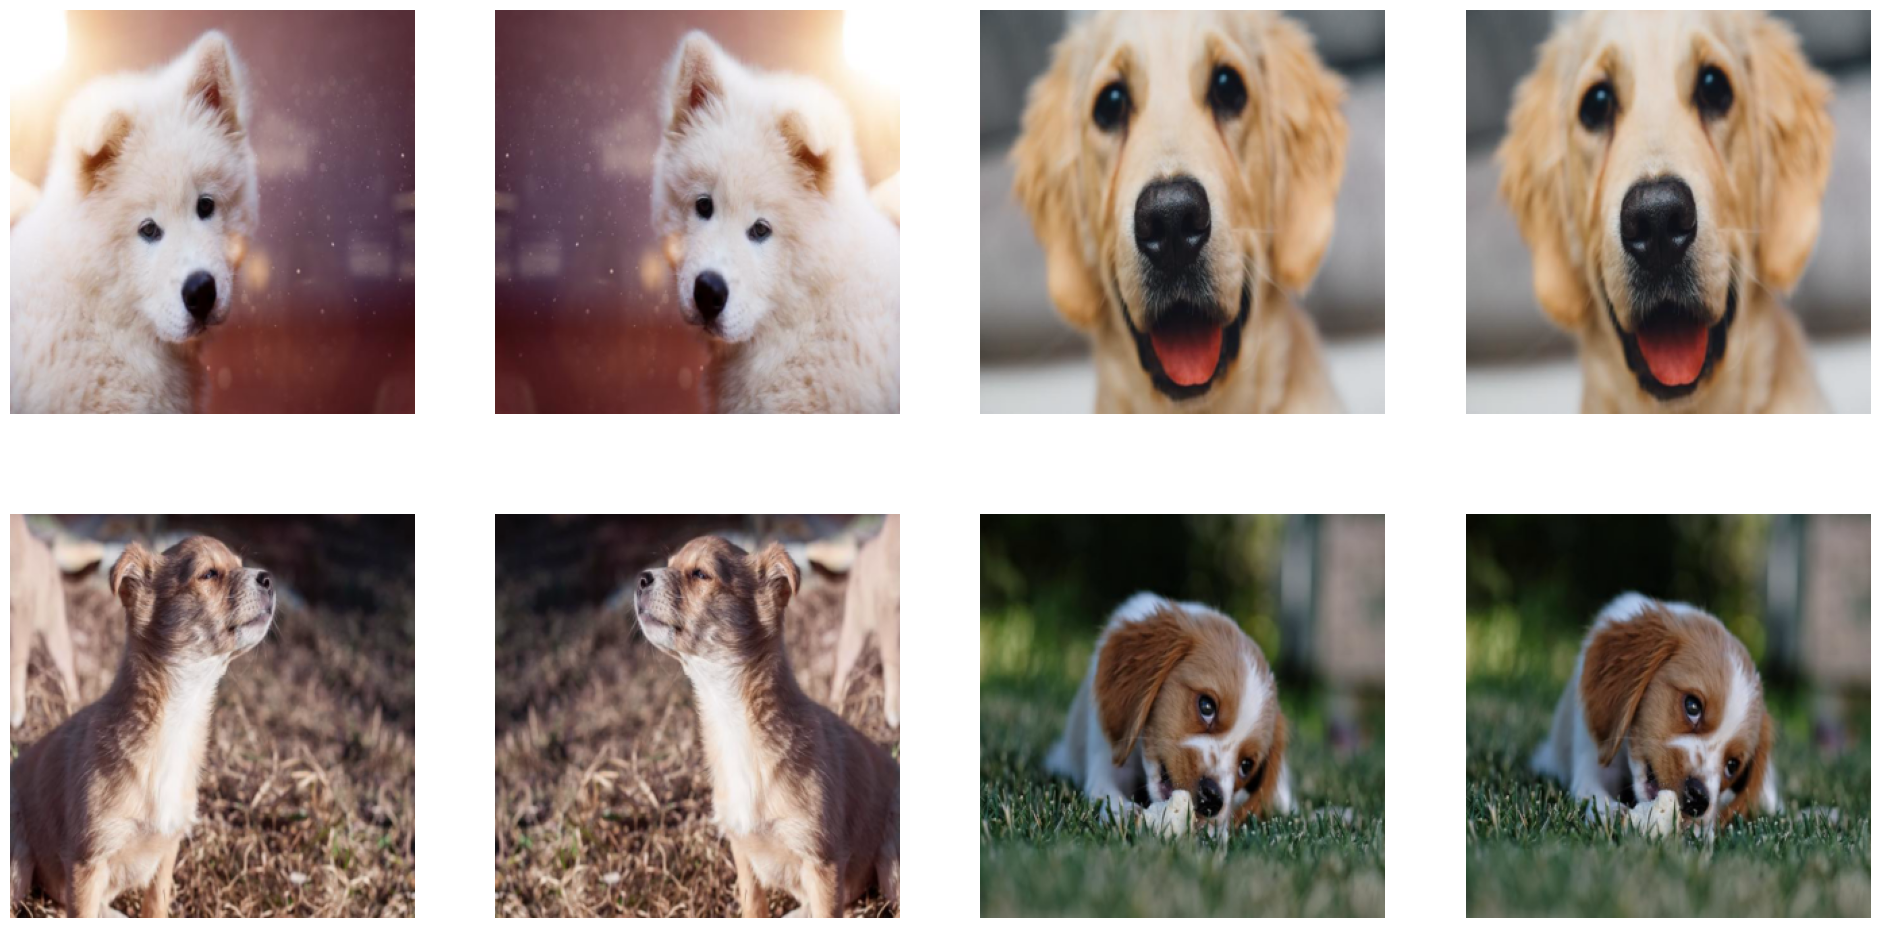

In [15]:
show_image(
    [image for pair in zip(images.as_cpu(), flipped_images.as_cpu()) for image in pair], columns=4
)